In [ ]:
#This is a model on the joints using a cnn.

Read Me:
We are doing supervised learning

We represent X using
We represnt Y using a 15 data tensor.

We are using the torchvision library.


In [1]:
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image

import pandas as pd
import ast

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [2]:
class PENNDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.pose_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pose_annotations)

    def __getitem__(self, idx):
        row = self.pose_annotations.iloc[idx]
        # Assuming the last column is the label
        label = torch.tensor(row[-1], dtype=torch.long)
        temp = [[float(y) for y in ast.literal_eval(x)] for x in row[:-1].values]
        features = torch.tensor(temp)
        return features, label

In [3]:
training_data = PENNDataset(
    csv_file  = "TrainTable.csv",
    root_dir="root",
    transform=ToTensor()
)
test_data = PENNDataset(
    csv_file = "TestTable.csv",
    root_dir="root",
    transform=ToTensor()
)

In [69]:
batch_size = 30

# Create train and test data loaders.
train_dataloader = DataLoader(training_data,batch_size=batch_size)
test_dataloader = DataLoader(test_data,batch_size=batch_size)


for X, y in test_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([30, 13, 3])
torch.Size([30])


C:\Users\ew21h\AppData\Local\Temp\ipykernel_17676\2233561234.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.long)


In [114]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        self.conv_relu_stack = nn.Sequential(
                                               nn.Conv1d(in_channels=13, out_channels=39, kernel_size = 1),
                                               nn.ReLU(),
                                               
                                                nn.Conv1d(in_channels=39, out_channels=39, kernel_size = 1),
                                               nn.ReLU()
        )
        self.linear = nn.Sequential(nn.Linear(117,512),
                                    nn.Linear(512,15)
                                    ,nn.LogSoftmax(dim=1))
                                              



    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear(x)
        
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv1d(13, 39, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(39, 39, kernel_size=(1,), stride=(1,))
    (3): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=117, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=15, bias=True)
    (2): LogSoftmax(dim=1)
  )
)


In [115]:
# Use cross-entropy loss as the loss function
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2

# Define a pytorch optimizer using stochastic gradient descent (SGD)
optimizer = torch.optim.SGD(model.parameters(),learning_rate)

In [116]:
import numpy as np
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()

    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X = torch.nan_to_num(X, nan=0.0)
        X = torch.where(torch.isinf(X), torch.full_like(X, 1e10), X)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        # Compute training loss
        loss = loss_fn(pred,y)

        # Backpropagation
        optimizer.zero_grad()

        # Calculate model gradients from the loss and optimize the network
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses.append(loss)

    return np.array(losses).mean()

In [117]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Set the model to eval mode
    model.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():	# no_grad mode doesn't compute gradients
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)		# compute predictions from X
            test_loss += loss_fn(pred,y)	# compute the test loss
            correct += (pred.argmax(dim=1)==y).sum().item()		# number of correct predictions
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

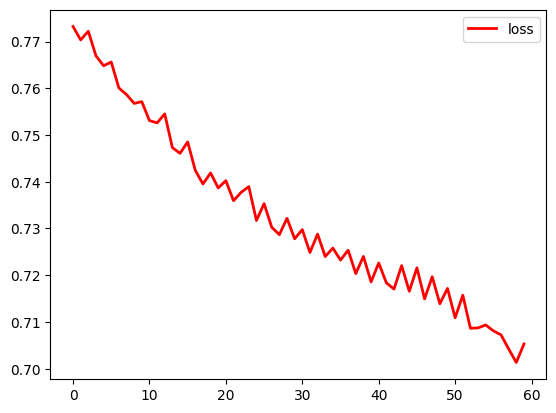

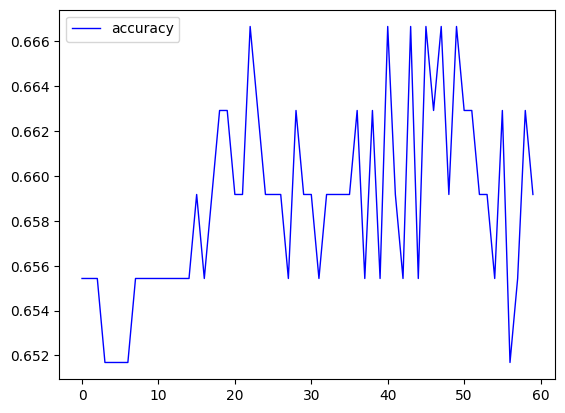

Epoch 61
-------------------------------
loss: 2.704237  [    0/  801]


In [ ]:
epochs = 150

# for plotting the training loss
history = {'losses': [], 'accuracies': []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['losses'].append(train(train_dataloader, model, loss_fn, optimizer))
    history['accuracies'].append(test(test_dataloader, model, loss_fn))
    plt.clf()
    fig1 = plt.figure()
    plt.plot(history['losses'], 'r-', lw=2, label='loss')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.clf()
    fig2 = plt.figure()
    plt.plot(history['accuracies'], 'b-', lw=1, label='accuracy')
    plt.legend()
#     display.clear_output(wait=True)
    display.display(plt.gcf())
print("Done!")